# Постановка задачи



## Задача о назначениях

Есть n таксистов и n пассажиров, ожидающих такси. Требуется назначить каждому
такси пассажира так, чтобы **затраты на путь до пассажиров были минимальны.**

# Определение задачи в терминах метода отжига

A - множество таксистов

T - множество клиентов, ожидающих заказ

С - матрица затрат на путь для каждого таксиста до каждого клиента

S - множество всех возможных назначений пассажиров такси

E - целевая функция, т.е. суммарные затраты времени каждого такси на то, чтобы добраться до места ожидания

T - температура процесса

# Реализация


Подключение библиотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import exp, log
from random import random, randint, shuffle

## Данные для задачи

Датасет содержит данные для задачи о назначениях для различных n, мы используем для n = 100 
(файл assign100.txt)

А также оптимальные решения 
(файл assignop.txt)

In [3]:
!wget http://people.brunel.ac.uk/~mastjjb/jeb/orlib/files/assign100.txt
!wget http://people.brunel.ac.uk/~mastjjb/jeb/orlib/files/assignopt.txt

--2021-12-20 11:39:39--  http://people.brunel.ac.uk/~mastjjb/jeb/orlib/files/assign100.txt
Resolving people.brunel.ac.uk (people.brunel.ac.uk)... 134.83.115.36
Connecting to people.brunel.ac.uk (people.brunel.ac.uk)|134.83.115.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30111 (29K) [text/plain]
Saving to: ‘assign100.txt’

assign100.txt       100%[===================>]  29.41K   115KB/s    in 0.3s    

2021-12-20 11:39:40 (115 KB/s) - ‘assign100.txt’ saved [30111/30111]

--2021-12-20 11:39:40--  http://people.brunel.ac.uk/~mastjjb/jeb/orlib/files/assignopt.txt
Resolving people.brunel.ac.uk (people.brunel.ac.uk)... 134.83.115.36
Connecting to people.brunel.ac.uk (people.brunel.ac.uk)|134.83.115.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 268 [text/plain]
Saving to: ‘assignopt.txt’

assignopt.txt       100%[===================>]     268  --.-KB/s    in 0s      

2021-12-20 11:39:40 (36.6 MB/s) - ‘assignopt.txt’ saved [268/268

Сериализация данных из файла

In [4]:
def read_data_by_rows(file):
    with open(file) as f:
        numbers = f.read().strip().split(' ')
        n = int(numbers[0])
        i = 1
        while i < len(numbers):
            j = 0
            row = []
            while j < n:
                row.append(int(numbers[i]))
                j += 1
                i += 1
            yield row

costs = pd.DataFrame.from_records(read_data_by_rows('assign100.txt'))
# Данные взяты из файла assignopt.txt
correct_solutions = {
    'assign100.txt' : 305,
    'assign200.txt' : 475,
    'assign300.txt' : 626,
    'assign400.txt' : 804,
    'assign500.txt' : 991,
    'assign600.txt' : 1176,
    'assign700.txt' : 1362,
    'assign800.txt' : 1552,
}

## Код

Определим вспомогательные функции для решения задачи

In [31]:
# Целевая функция, которую нужно минимизировать
def E(assignments, costs) -> float:
  # assignmens[i] = j, i-тому таксисту j-тый пассажир
  # costs[i][j] - затраты для i-того таксиста на путь до j-того пассажира 
  total_cost = 0
  for i in range(len(assignments)):
    total_cost += costs[i][assignments[i]]
  return total_cost

# Функция понижения температуры
def T(t) -> float:
    k = 0.99
    return k * t


# Функция вероятности перехода к следующему состоянию
def h(d_E, t) -> float:
    if d_E < 0:
        return 1
    return exp(-d_E/t)


# Проверка перехода в новое состояние
def check_prob(v) -> bool:
    d = random()
    #print("{:.2f}".format(d))
    return d < v

Реализация непосредственно *метода отжига*

In [32]:
def anneal():
    cur_solution = list(range(len(costs[0])))
    shuffle(cur_solution)
    f = E(cur_solution, costs)

    f_global_min = f
    max_temp = 5000
    temp = max_temp
    k = 1

    candidate_mins=[[],[]]
    all_values=[[],[]]
    temp_values=[[],[]]

    while temp > 0.1:
        if f_global_min > f:
            f_global_min = f
            candidate_mins[0].append(k)
            candidate_mins[1].append(f_global_min)

        while True:
            # Случайная перестановка двух назначений
            i = randint(0, len(cur_solution) - 1)
            j = randint(0, len(cur_solution) - 1)
            cur_solution[i], cur_solution[j] = cur_solution[j], cur_solution[i]
            cur_solution[i:j + 1]
            #print(i, j)
            #print("После перестановки: ...", cur_solution[i - 1], cur_solution[i], 
                  #cur_solution[i + 1], "...", cur_solution[j - 1], cur_solution[j], cur_solution[j + 1])

            # Подсчет нового значения целевой функции и вероятности перехода
            f_new = E(cur_solution, costs)
            prob = h(f_new - f, temp)

            #print("{:.2f} -> {:.2f}:\t{:.2f}".format(f, f_new, prob))

            # Вероятностный переход
            if check_prob(prob):
                all_values[0].append(k)
                all_values[1].append(f_new)
                f = f_new
                break
            else:
                cur_solution[i], cur_solution[j] = cur_solution[j], cur_solution[i]

        #if k >= 200 and k <= 300:
        #  print("[{}:{:.2f}]\t{}".format(k, temp, f))
        
        temp_values[0].append(k)
        temp_values[1].append(temp)

        temp = T(temp)
        k += 1

    print('Кол-во итераций:', str(k))
    print('Найденный минимум: ', str(f_global_min))
    print("Абсолютный минимум:", correct_solutions['assign100.txt'])

    return all_values, candidate_mins, temp_values

## Полученный результат

In [33]:
f1, f2, temp = anneal()

Кол-во итераций: 1078
Найденный минимум:  568
Абсолютный минимум: 305


Визуализация результата

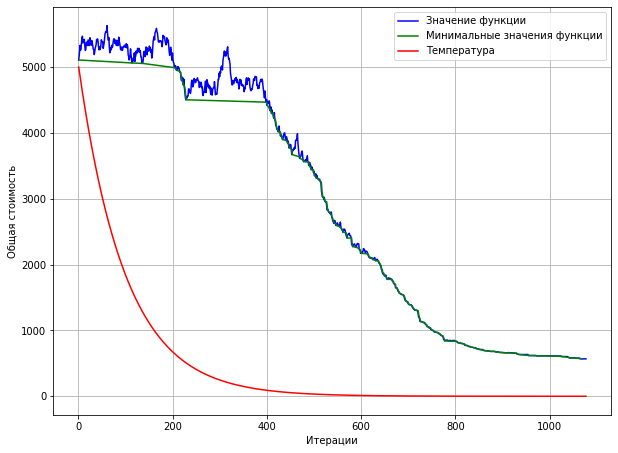

In [34]:
plt.figure(figsize=(10, 7.5))
plt.plot(f1[0], f1[1], 'b',
         f2[0], f2[1], 'g',
         temp[0], temp[1], 'r')
plt.legend(["Значение функции", "Минимальные значения функции", "Температура"])
plt.xlabel("Итерации")
plt.ylabel("Общая стоимость")
plt.grid(True)
plt.show()

## Множественная проверка

Визуализация нескольких выполнений программы на одном датасете и вывод некоторой статистики.

In [35]:
res = []
for i in range(10):
  f1, f2, temp = anneal()
  res.append(f2[1][-1])

Кол-во итераций: 1078
Найденный минимум:  547
Абсолютный минимум: 305
Кол-во итераций: 1078
Найденный минимум:  613
Абсолютный минимум: 305
Кол-во итераций: 1078
Найденный минимум:  586
Абсолютный минимум: 305
Кол-во итераций: 1078
Найденный минимум:  531
Абсолютный минимум: 305
Кол-во итераций: 1078
Найденный минимум:  570
Абсолютный минимум: 305
Кол-во итераций: 1078
Найденный минимум:  577
Абсолютный минимум: 305
Кол-во итераций: 1078
Найденный минимум:  562
Абсолютный минимум: 305
Кол-во итераций: 1078
Найденный минимум:  541
Абсолютный минимум: 305
Кол-во итераций: 1078
Найденный минимум:  556
Абсолютный минимум: 305
Кол-во итераций: 1078
Найденный минимум:  598
Абсолютный минимум: 305


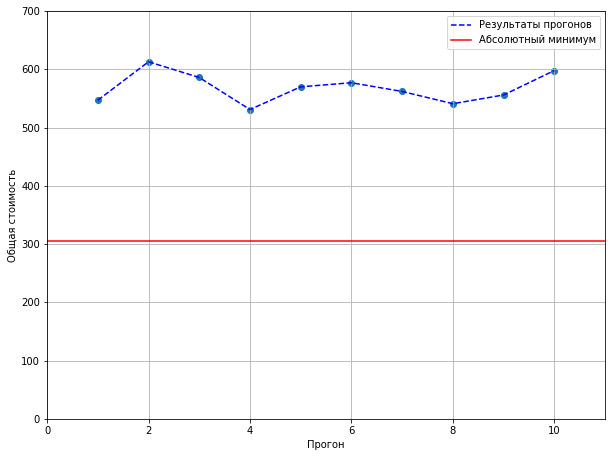

In [39]:
plt.figure(figsize=(10, 7.5))
plt.gca().set_ylim([0, 700])
plt.gca().set_xlim([0, 11])
plt.ylabel("Общая стоимость")
plt.xlabel("Прогон")
plt.scatter(range(1, 11), res)
plt.plot(range(1, 11), res, 'b--')
plt.axhline(y=correct_solutions['assign100.txt'], color='red')
plt.legend(["Результаты прогонов", "Абсолютный минимум"])
plt.grid(True)
plt.show()